# Настройка модели

In [2]:
import pickle
from pathlib import Path

import hyperopt as hp
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from hyperopt import fmin, hp, tpe
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
)
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

plt.rcParams["figure.figsize"] = [15, 5]

pd.options.plotting.backend = "plotly"

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 20)
pd.set_option("display.width", 500)
pd.set_option("display.expand_frame_repr", False)

np.set_printoptions(precision=6, suppress=True)

np.random.seed(2022)

In [2]:
polygon_df = pd.read_pickle("./../data/polygons.pkl")

In [3]:
calendar_df = pd.read_pickle("./../data/calendar.pkl")
calendar_df[calendar_df["event_dttm"].isin(["2020-01-01", "2020-02-01"])]

,event_time_id,event_ts,event_dttm,year,month,day,weekday,hour,weekend,holidays,month_cos,month_sin,weekday_cos,weekday_sin,hour_cos,hour_sin
8760,8760,1577836800,2020-01-01,2020,1,1,2,0,0,1,0.866211,0.500000,-0.222534,0.975098,1.0,0.0
9504,9504,1580515200,2020-02-01,2020,2,1,5,0,1,0,0.500000,0.866211,-0.222534,-0.975098,1.0,0.0


In [4]:
mart_df = pd.read_pickle("./../data/mart_sample.pkl")

print(mart_df.shape)
mart_df.tail()

(5100000, 69)


,polygon_id,event_time_id,lon,lat,year,month,day,weekday,hour,weekend,holidays,month_cos,month_sin,weekday_cos,weekday_sin,hour_cos,hour_sin,posts_count,posts_count_lag_28,likescount_mean_lag_28,likescount_std_lag_28,commentscount_mean_lag_28,commentscount_std_lag_28,symbols_cnt_mean_lag_28,symbols_cnt_std_lag_28,words_cnt_mean_lag_28,words_cnt_std_lag_28,hashtags_cnt_mean_lag_28,hashtags_cnt_std_lag_28,mentions_cnt_mean_lag_28,mentions_cnt_std_lag_28,links_cnt_mean_lag_28,links_cnt_std_lag_28,emoji_cnt_mean_lag_28,emoji_cnt_std_lag_28,posts_count_lag_28_roll_15_mean,likescount_mean_lag_28_roll_15_mean,likescount_std_lag_28_roll_15_mean,commentscount_mean_lag_28_roll_15_mean,commentscount_std_lag_28_roll_15_mean,symbols_cnt_mean_lag_28_roll_15_mean,symbols_cnt_std_lag_28_roll_15_mean,words_cnt_mean_lag_28_roll_15_mean,words_cnt_std_lag_28_roll_15_mean,hashtags_cnt_mean_lag_28_roll_15_mean,hashtags_cnt_std_lag_28_roll_15_mean,mentions_cnt_mean_lag_28_roll_15_mean,mentions_cnt_std_lag_28_roll_15_mean,links_cnt_mean_lag_28_roll_15_mean,links_cnt_std_lag_28_roll_15_mean,emoji_cnt_mean_lag_28_roll_15_mean,emoji_cnt_std_lag_28_roll_15_mean,posts_count_lag_28_roll_15_std,likescount_mean_lag_28_roll_15_std,likescount_std_lag_28_roll_15_std,commentscount_mean_lag_28_roll_15_std,commentscount_std_lag_28_roll_15_std,symbols_cnt_mean_lag_28_roll_15_std,symbols_cnt_std_lag_28_roll_15_std,words_cnt_mean_lag_28_roll_15_std,words_cnt_std_lag_28_roll_15_std,hashtags_cnt_mean_lag_28_roll_15_std,hashtags_cnt_std_lag_28_roll_15_std,mentions_cnt_mean_lag_28_roll_15_std,mentions_cnt_std_lag_28_roll_15_std,links_cnt_mean_lag_28_roll_15_std,links_cnt_std_lag_28_roll_15_std,emoji_cnt_mean_lag_28_roll_15_std,emoji_cnt_std_lag_28_roll_15_std
69574195,7023,10195,30.390625,59.9375,2020,2,29,5,19,1,0,0.5,0.866211,-0.222534,-0.975098,0.258789,-0.965820,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.091003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69574196,7023,10196,30.390625,59.9375,2020,2,29,5,20,1,0,0.5,0.866211,-0.222534,-0.975098,0.500000,-0.866211,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.091003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69574197,7023,10197,30.390625,59.9375,2020,2,29,5,21,1,0,0.5,0.866211,-0.222534,-0.975098,0.707031,-0.707031,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.091003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69574198,7023,10198,30.390625,59.9375,2020,2,29,5,22,1,0,0.5,0.866211,-0.222534,-0.975098,0.866211,-0.500000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.091003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69574199,7023,10199,30.390625,59.9375,2020,2,29,5,23,1,0,0.5,0.866211,-0.222534,-0.975098,0.965820,-0.258789,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.091003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
split_valid_id, split_test_id = sorted(
    calendar_df.loc[
        calendar_df["event_dttm"].isin(["2020-01-01", "2020-02-01"]), "event_time_id"
    ].values.tolist()
)
print(f"split_valid_id: {split_valid_id}\nsplit_test_id: {split_test_id}")

# split_valid_id = calendar_df.loc[calendar_df["event_dttm"] == "2020-02-01", "event_time_id"].values[0]
# print(f"split_valid_id: {split_valid_id}")

ignore_columns = ["polygon_id", "event_time_id", "posts_count"]
feature_columns = [col for col in mart_df.columns if col not in ignore_columns]

print(f"len(feature_columns): {len(feature_columns)}")

split_valid_id: 8760
split_test_id: 9504
len(feature_columns): 66


In [6]:
train_filter = mart_df["event_time_id"] < split_valid_id
valid_filter = (mart_df["event_time_id"] >= split_valid_id) & (
    mart_df["event_time_id"] < split_test_id
)
# valid_filter = mart_df["event_time_id"] >= split_valid_id

x_train = mart_df.loc[train_filter, feature_columns]
y_train = mart_df.loc[train_filter, "posts_count"]

x_valid = mart_df.loc[valid_filter, feature_columns]
y_valid = mart_df.loc[valid_filter, "posts_count"]

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(4380000, 66) (4380000,)
(372000, 66) (372000,)


## Подбор параметров модели

In [ ]:
def parameters_opt(x_train, y_train, max_evals):
    def objective(params):

        print("\n############## New Run ################")
        print("PARAMETERS: ")
        print(params)
        print()

        cv = TimeSeriesSplit(n_splits=6)
        scores = cross_val_score(
            lgb.LGBMRegressor(**params),
            x_train,
            y_train,
            scoring="neg_mean_absolute_error",
            cv=cv,
            n_jobs=1,
            # fit_params={"early_stopping_rounds": 30, "eval_set": [[x_valid, y_valid]]},
        )
        print(scores)
        score = scores.mean()
        print(score)

        return -score

    space = {
        "n_estimators": hp.uniformint("n_estimators", 20, 750),
        "learning_rate": hp.loguniform("learning_rate", np.log(0.0001), np.log(0.5)),
        "max_depth": hp.uniformint("max_depth", 8, 15),
        "num_leaves": hp.uniformint("num_leaves", 20, 250),
        "max_bin": hp.uniformint("max_bin", 10, 255),
        "min_child_samples": hp.uniformint("min_child_samples", 5, 150),
        "subsample": hp.quniform("subsample", 0.5, 1, 0.05),
        "reg_alpha": hp.quniform("reg_alpha", 0.5, 3, 0.05),
        "reg_lambda": hp.quniform("reg_lambda", 0.5, 3, 0.05),
        "colsample_bytree": hp.quniform("colsample_bytree", 0.5, 1, 0.05),
        "verbose": -1,
        "n_jobs": -1,
        "random_state": 42,
    }

    best_parameters = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=max_evals)

    best_parameters["verbose"] = -1
    best_parameters["n_jobs"] = -1
    best_parameters["random_state"] = 42
    best_parameters["n_estimators"] = int(best_parameters["n_estimators"])
    best_parameters["max_depth"] = int(best_parameters["max_depth"])
    best_parameters["num_leaves"] = int(best_parameters["num_leaves"])
    best_parameters["max_bin"] = int(best_parameters["max_bin"])
    best_parameters["min_child_samples"] = int(best_parameters["min_child_samples"])

    return best_parameters


In [ ]:
params = parameters_opt(x_train, y_train, 5)
print(params)

## Обучение модели

In [7]:
params = {
    "colsample_bytree": 0.75,
    "learning_rate": 0.01215079332778904,
    "max_bin": 84,
    "max_depth": 11,
    "min_child_samples": 19,
    "n_estimators": 509,
    "num_leaves": 26,
    "reg_alpha": 1.7000000000000002,
    "reg_lambda": 1.05,
    "subsample": 0.8,
    "verbose": -1,
    "n_jobs": -1,
    "random_state": 42,
}

print(params)

{'colsample_bytree': 0.75, 'learning_rate': 0.01215079332778904, 'max_bin': 84, 'max_depth': 11, 'min_child_samples': 19, 'n_estimators': 509, 'num_leaves': 26, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.05, 'subsample': 0.8, 'verbose': -1, 'n_jobs': -1, 'random_state': 42}


In [8]:
model = lgb.LGBMRegressor(first_metric_only=True, **params)

model.fit(
    x_train,
    y_train,
    eval_metric="l1",
    eval_set=[(x_valid, y_valid)],
    feature_name=feature_columns,
    # early_stopping_rounds = 10,
    verbose=-1,
)

forecast = model.predict(x_valid)

print(f"model score: {model.score(x_valid, y_valid)}")
print(f"LightGBM MAE: {mean_absolute_error(y_valid, forecast):.4f}")
print(f"LightGBM MAPE: {mean_absolute_percentage_error(y_valid, forecast):.4f}")
print(f"LightGBM MSE: {mean_squared_error(y_valid, forecast):.4f}")
print(f"LightGBM RMSE: {mean_squared_error(y_valid, forecast, squared=False):.4f}")

df = pd.concat([y_valid.reset_index(drop=True), pd.Series(forecast, name="forecast")], axis=1)
df = df[df["forecast"] != 0]
print(f"error: {(np.abs(df['forecast'] - df['posts_count']) / df['forecast']).mean()}")

c:\Users\Sultan\Documents\work\semestr_11\MLID\.venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


model score: 0.4655497732136169
LightGBM MAE: 0.1708
LightGBM MAPE: 290896234052098.5000
LightGBM MSE: 2.2534
LightGBM RMSE: 1.5011
error: 1.4024138820957794


### Значимые параметры

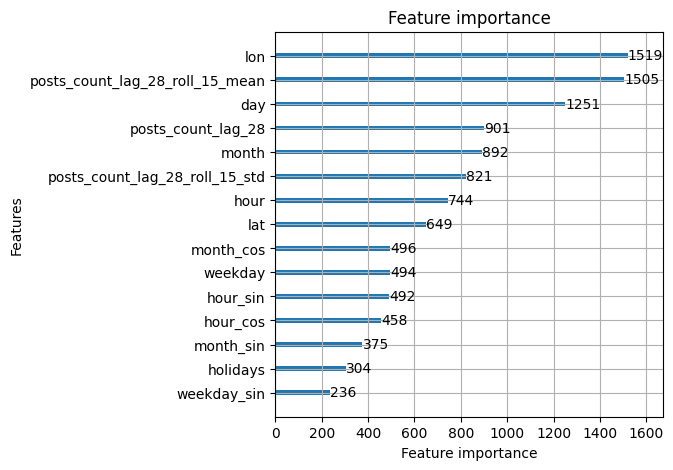

In [9]:
plt.rcParams["figure.figsize"] = [5, 5]

lgb.plot_importance(model, max_num_features=15, importance_type="split")
plt.show()

In [10]:
feat_imp_df = pd.DataFrame(
    list(zip(model.feature_name_, model.feature_importances_)),
    columns=["feature", "gain"],
).sort_values("gain", ascending=False)
feat_imp_df["gain"] = feat_imp_df["gain"] * 100 / feat_imp_df["gain"].sum()
print(feat_imp_df.head(15))

important_features = feat_imp_df[feat_imp_df["gain"] > 0.005]["feature"].values.tolist()
print(f"len(important_features): {len(important_features)}")

                            feature       gain
0                               lon  11.937132
32  posts_count_lag_28_roll_15_mean  11.827112
4                               day   9.831041
15               posts_count_lag_28   7.080550
3                             month   7.009823
49   posts_count_lag_28_roll_15_std   6.451866
6                              hour   5.846758
1                               lat   5.100196
9                         month_cos   3.897839
5                           weekday   3.882122
14                         hour_sin   3.866405
13                         hour_cos   3.599214
10                        month_sin   2.946955
8                          holidays   2.388998
12                      weekday_sin   1.854617
len(important_features): 33


### Переобучение модели

In [11]:
tuned_x_train = mart_df.loc[train_filter, important_features]
tuned_x_valid = mart_df.loc[valid_filter, important_features]

print(tuned_x_train.shape, y_train.shape)
print(tuned_x_valid.shape, y_valid.shape)

tuned_model = lgb.LGBMRegressor(first_metric_only=True, **params)

tuned_model.fit(
    tuned_x_train,
    y_train,
    eval_metric="l1",
    eval_set=[(tuned_x_valid, y_valid)],
    feature_name=important_features,
    # early_stopping_rounds = 10,
    verbose=-1,
)

forecast = tuned_model.predict(tuned_x_valid)

print(f"model score: {tuned_model.score(tuned_x_valid, y_valid)}")
print(f"LightGBM MAE: {mean_absolute_error(y_valid, forecast):.4f}")
print(f"LightGBM MAPE: {mean_absolute_percentage_error(y_valid, forecast):.4f}")
print(f"LightGBM MSE: {mean_squared_error(y_valid, forecast):.4f}")
print(f"LightGBM RMSE: {mean_squared_error(y_valid, forecast, squared=False):.4f}")

df = pd.concat([y_valid.reset_index(drop=True), pd.Series(forecast, name="forecast")], axis=1)
df = df[df["forecast"] != 0]
print(f"error: {(np.abs(df['forecast'] - df['posts_count']) / df['forecast']).mean()}")

(4380000, 33) (4380000,)
(372000, 33) (372000,)


c:\Users\Sultan\Documents\work\semestr_11\MLID\.venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


model score: 0.4752842933369136
LightGBM MAE: 0.1705
LightGBM MAPE: 290786702303730.0000
LightGBM MSE: 2.2123
LightGBM RMSE: 1.4874
error: 2.286725117705076


## Визуализация результата

In [12]:
plot_polygons = (
    mart_df.loc[
        valid_filter,
        ["event_time_id", "polygon_id", "posts_count"],
    ]
    .groupby("polygon_id")["posts_count"]
    .sum()
    .sort_values()
    .tail(5)
    .index.tolist()
)

print(plot_polygons)

[1235, 5957, 6076, 5161, 2714]


In [13]:
forecast_df = mart_df.loc[
    valid_filter,
    ["event_time_id", "polygon_id", "posts_count"],
]
forecast_df["forecast"] = [round(max(y, 0)) for y in forecast]
forecast_df = forecast_df[
    # forecast_df["polygon_id"] == 2122
    forecast_df["polygon_id"].isin(plot_polygons)
]

forecast_df = pd.concat(
    [
        forecast_df[["event_time_id", "polygon_id", "posts_count"]].assign(
            is_real="real"
        ),
        forecast_df[["event_time_id", "polygon_id", "forecast"]]
        .rename(columns={"forecast": "posts_count"})
        .assign(is_real="forecast"),
    ]
)
forecast_df["polygon"] = (
    forecast_df["is_real"].astype("str") + "_" + forecast_df["polygon_id"].astype("str")
)

forecast_df.plot(x="event_time_id", y="posts_count", color="polygon")

## Сохранение результатов

In [ ]:
model_dir = Path("./../model")

if not model_dir.exists():
    model_dir.mkdir()

features_path = Path(model_dir, "features.pkl")
parameters_path = Path(model_dir, "parameters.pkl")
model_path = Path(model_dir, "model.pkl")

In [ ]:
with open(features_path, "wb") as f_dst:
    pickle.dump(important_features, f_dst)

with open(parameters_path, "wb") as f_dst:
    pickle.dump(params, f_dst)

with open(model_path, "wb") as f_dst:
    pickle.dump(tuned_model, f_dst)

# Open

In [3]:
with open('../model/mart_feat.pkl', 'rb') as f:
    mart_df = pd.read_pickle(f)

mart_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../model/mart_feat.pkl'